# Import Libraries

In [32]:
import nltk
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import ticker
import time
import math
import numpy as np
import random
from scripts.helpers import load_data, process_intents, bag_of_words

In [33]:
intents_dict, response_dict = load_data('../../clean_data/intents_enriched.json')
n_categories = len(intents_dict)
print(n_categories)

13


Lemmatize, tokenize and extract intent tags. See scripts/helpers.py for more details

In [34]:
words, intents, words_tokenized = process_intents(intents_dict)

In [35]:
lemmatizer = WordNetLemmatizer()
train_x = []
train_y = []

for pair in words_tokenized:
    words_encoded = []
    pattern_words = pair[0] # list of words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    for w in words:
        words_encoded.append(1 if w in pattern_words else 0)

    intents_encoded = [0] * len(intents)
    intents_encoded[intents.index(pair[1])] = 1 # pair[1] is the intent

    train_x.append(words_encoded)
    train_y.append(intents_encoded)

train_x = np.array(train_x)
train_y = np.array(train_y)

Representation of the bag of words

In [36]:
bag = bag_of_words('Hello', words, lemmatizer)
print(bag)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
for i, w in enumerate(words):
    if bag[i] == 1:
        print(w)

hello


In [38]:
x_tensor = torch.from_numpy(train_x).float()
y_tensor = torch.from_numpy(train_y).float()
x_tensor.shape, y_tensor.shape

(torch.Size([904, 257]), torch.Size([904, 13]))

An RNN architecture with two linear layers and a softmax output layer. The ReLU activation function is used followed by a dropout layer in the typical fashion.

In [39]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.ReLU(hidden)
        hidden = self.dropout(hidden)
        output = self.h2o(hidden)
        output = self.ReLU(output)
        output = self.dropout(output)
        output = self.softmax(output + 1e-9) # to avoid log(0)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# n_hidden = 128
n_hidden = 256
rnn = RNN(len(words), n_hidden, len(intents))

In [40]:
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(torch.from_numpy(bag).view(1, -1), hidden)

Test output before training

In [41]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return intents[category_i], category_i

print(categoryFromOutput(output))

('goodbye', 3)


In [42]:
criterion = nn.NLLLoss()
learning_rate = 0.001

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    output, hidden = rnn(line_tensor, hidden)

    loss = criterion(output, category_tensor)
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Pick train inputs randomly to avoid overfitting.

In [43]:
def randomChoice(l):
    if len(l) == 0:
        return None
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(intents)
    line = randomChoice(intents_dict[category])
    category_tensor = torch.tensor([intents.index(category)], dtype=torch.long)
    line_tensor = torch.from_numpy(bag_of_words(line, words, lemmatizer)).view(1, -1)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = thanks / line = Thank you for that.
category = thanks / line = Thank you very much. You're a miracle worker.
category = blood_pressure_search / line = Pull up blood pressure history by ID.
category = search_hospital_by_type / line = Find children's hospital
category = adverse_drug / line = Do clopidogrel and divalproex have bad side effects?
category = search_pharmacy_by_name / line = Find nearby CVS
category = goodbye / line = Till next time!
category = search_hospital_by_params / line = Find hospital within 10 miles
category = search_hospital_by_type / line = Find children's hospital
category = options / line = What can I do right now?


Train the model

In [44]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iteration number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.6002 Which medicines have adverse interactions? / search_blood_pressure_by_patient_id ✗ (adverse_drug)
10000 10% (0m 11s) 2.6185 Hello and good morning. Hope you're having a nice day. / goodbye ✗ (greeting)
15000 15% (0m 17s) 2.6992 Show a hospital / search_hospital_by_type ✗ (hospital_search)
20000 20% (0m 23s) 2.8499 I want to record my blood pressure numbers / search_blood_pressure_by_patient_id ✗ (blood_pressure)
25000 25% (0m 29s) 1.4134 P515113 blood pressure data / search_blood_pressure_by_patient_id ✓
30000 30% (0m 35s) 2.6430 Find nearby CVS / pharmacy_search ✗ (search_pharmacy_by_name)
35000 35% (0m 41s) 0.5309 Locate nearyby pharmacies / pharmacy_search ✓
40000 40% (0m 47s) 0.0712 How can you assist me right now? / options ✓
45000 45% (0m 53s) 2.5742 Amazing to see you and good evening. How are you? / options ✗ (greeting)
50000 50% (0m 59s) 0.1983 Display hospital near me / hospital_search ✓
55000 55% (1m 5s) 0.0602 Locate pharmacies near my position / phar

Might be overfit as-is. Will need hyperparam tuning and testing data

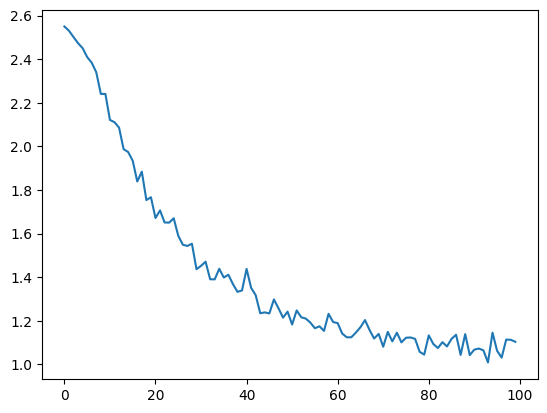

In [45]:
plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_116445/1655712744.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + intents, rotation=90)
/tmp/ipykernel_116445/1655712744.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + intents)


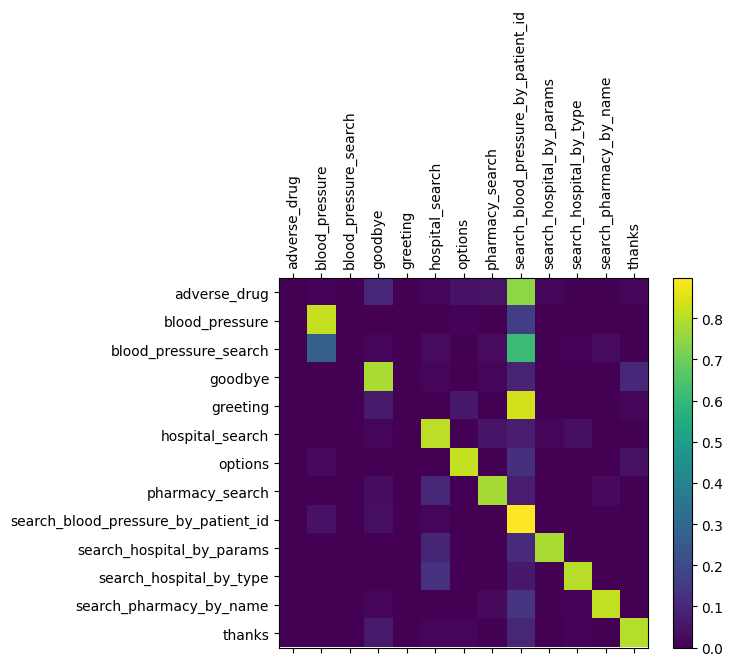

In [46]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    output, hidden = rnn(line_tensor, hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = intents.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + intents, rotation=90)
ax.set_yticklabels([''] + intents)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [47]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(torch.from_numpy(bag_of_words(input_line, words, lemmatizer)).view(1, -1))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, intents[category_index]))
            predictions.append([value, intents[category_index]])

predict('Hey there!')
predict('Thanks for that!')
predict('Find me a hospital')


> Hey there!
(-1.48) search_blood_pressure_by_patient_id
(-2.12) goodbye
(-2.67) pharmacy_search

> Thanks for that!
(-0.81) thanks
(-1.07) goodbye
(-3.28) search_blood_pressure_by_patient_id

> Find me a hospital
(-0.12) hospital_search
(-4.24) search_hospital_by_params
(-4.24) search_hospital_by_type


In [48]:
# Save the model
torch.save(rnn, '../clean_data/models/intents_classifier.pth')